<a href="https://colab.research.google.com/github/jaysonbarretti/OEE_LSTM/blob/master/LSTM_OEE_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet OEE - Performance des machines avec LSTM

## Étape 1 : Collecte de données (Data collection)

Importer les bibliothèques :

In [ ]:
import pandas as pd              # bibliothèque pour le traitement des valeurs numériques (vecteurs et matrices)
import numpy as np               # bibliothèque le traitement des données via des dataframes
import matplotlib.pyplot as plt  # bibliothèque utilisées pour l'analyse graphique
import math                      # bibliothèque pour travailler avec la date et l'heure
import datetime                  # bibliothèque pour travailler avec des expressions mathématiques

from sklearn.preprocessing import MinMaxScaler        # bibliothèque pour normaliser les données
from sklearn.metrics       import mean_squared_error, r2_score  # biblioteca para avaliar a performance do modelo de rede neural

# bibliothèque de création du réseau neuronal
from keras.models    import Sequential
from keras.layers    import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models    import model_from_json

# bibliothèque pour régle de hyperparamètres
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection     import GridSearchCV

Téléverser le jeu de données (dataset) :

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Créer le dataframe et visualiser le jeu de données :

In [ ]:
dataset = pd.read_excel('/content/drive/My Drive/OEE_ULaval/OEE_machine_complet.xlsx', index_col = 0)
dataset.head()

,T_Oper_min,T_N-Prog_Prod_min,T_Prog_Prod_min,T_Arrêt_min,T_Prod_Réel_min,Disponibilité%,Prod_Téorique,Prod_Bonnes,Prod_défectueuses,Prod_Réel,Qualité%,Productivité%,OEE%,Unnamed: 14
Date,,,,,,,,,,,,,,
2018-11-12,480,60,420,35,385,0.916667,360,330,20,350,0.942857,0.972222,0.840278,NaN
2018-11-13,480,30,420,15,405,0.964286,360,330,20,350,0.942857,0.972222,0.883929,NaN
2018-11-14,480,30,420,5,415,0.988095,360,280,20,300,0.933333,0.833333,0.768519,NaN
2018-11-15,480,60,420,60,360,0.857143,360,330,20,350,0.942857,0.972222,0.785714,NaN
2018-11-16,480,40,420,30,390,0.928571,380,340,20,360,0.944444,0.947368,0.830827,NaN


In [ ]:
dataset_100 = dataset.iloc[399:499]
dataset_100.shape

(100, 14)

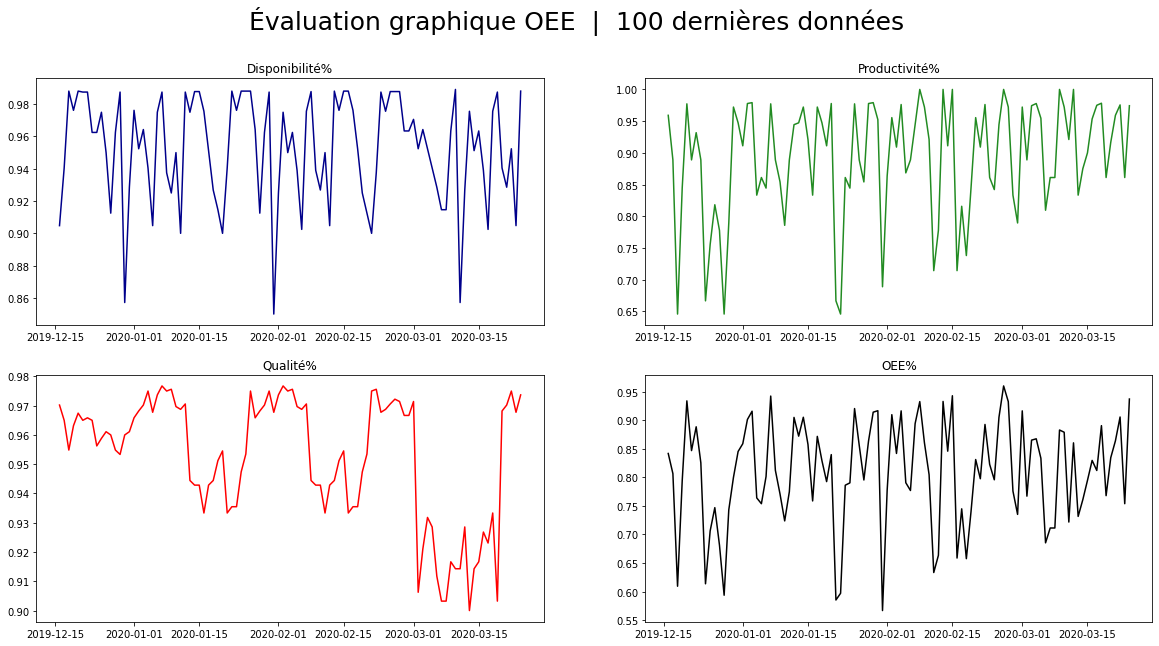

In [ ]:
fig1, f1_axes = plt.subplots(ncols=2, nrows=2, figsize = (20,10))
fig1.suptitle('Évaluation graphique OEE  |  100 dernières données', size = 25)
f1_axes[0,0].set_title('Disponibilité%')
f1_axes[0,0].plot(dataset_100['Disponibilité%'], color = 'darkblue')
f1_axes[1,0].set_title('Qualité%')
f1_axes[1,0].plot(dataset_100['Qualité%'], color = 'red')
f1_axes[0,1].set_title('Productivité%')
f1_axes[0,1].plot(dataset_100['Productivité%'], color = 'forestgreen')
f1_axes[1,1].set_title('OEE%')
f1_axes[1,1].plot(dataset_100['OEE%'], color = 'black')

In [ ]:
df = dataset.filter(items = dataset[['Disponibilité%','Productivité%','Qualité%','OEE%']])
df.describe()

,Disponibilité%,Productivité%,Qualité%,OEE%
count,499.000000,499.000000,499.000000,499.000000
mean,0.952451,0.883943,0.948050,0.798363
std,0.032428,0.083265,0.024924,0.084316
min,0.850000,0.645833,0.871429,0.550000
25%,0.928571,0.833333,0.931818,0.745063
50%,0.962500,0.888889,0.954545,0.804878
75%,0.976190,0.955556,0.969697,0.861954
max,0.989130,1.000000,0.976744,0.960366


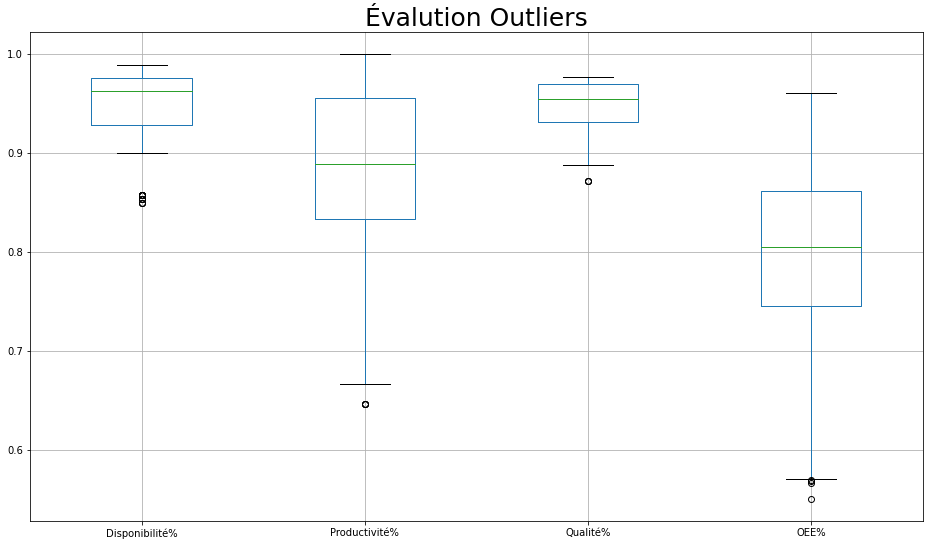

In [ ]:
plt.figure(figsize = (16,9))
plt.title('Évalution Outliers', size = 25)
df.boxplot()

# Étape 2 : Préparation des données (Data preparation)

En ne prenant que les valeurs de l'attribut choisi du dataframe pour qu'il soit possible de transformer la dimension de 1D en 2D (Numpy pour transformation de matrices) :

In [ ]:
df = dataset['Qualité%'].values 
df = df.astype('float32')
df = df.reshape(-1, 1) # transformer la dimension de 1D en 2D pour qu'il soit possible de normaliser l'attribut choisi.
df.shape

(499, 1)

Normalisation des données (normaliser les données pour améliorer les performances du réseau neuronal qui fonctionnera avec des données comprises entre «0» et «1») :

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df.shape

(499, 1)

Diviser les données (dataframe) en données d'entraînement et données de test : (notez que la division n'est pas aléatoire, mais séquentielle).

In [ ]:
train_size = int(len(df) * 0.67) 
test_size = len(df) - train_size 
print('- Taille du jeu de donnés pour entraîner le modèle : {}'.format(train_size))
print('- Taille du jeu de donnés pour essayer le modèle : {}\n'.format(test_size))

train, test = df[0:train_size,:], df[train_size:len(df),:]
print("- Jeu de données pour entraîner le modèle : {}".format(train.shape))
print("- Jeu de données pour essayer le modèle : {}".format(test.shape))

- Taille du jeu de donnés pour entraîner le modèle : 334
- Taille du jeu de donnés pour essayer le modèle : 165

- Jeu de données pour entraîner le modèle : (334, 1)
- Jeu de données pour essayer le modèle : (165, 1)


In [ ]:
# création d'une fonction qui considérera les données passées (look_back) comme influençant la prédiction des données :
look_back = 1
def create_dataset(df, look_back):
	df_X, df_Y = [], []
	for i in range(len(df) - look_back - 1):  
		df_X.append(df[i:(i + look_back), 0])
		df_Y.append(df[i + look_back, 0])
	return np.array(df_X), np.array(df_Y)

Séparation des données pour les données d'entraînement et les données de test :

In [ ]:
look_back = 3 # (timesteps)
train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)

print("Selon la documentation Keras (Ref.: LSTM Layer) le format des jeux de données d'entrées doivent être comme un tenseur 3D avec la forme [batch, timesteps, feature] :")
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print('- Format du jeu de données pour entraîner le modèle :', train_X.shape, train_Y.shape)
print('- Format du jeu de données pour tester le modèle :', test_X.shape,  test_Y.shape)

Selon la documentation Keras (Ref.: LSTM Layer) le format des jeux de données d'entrées doivent être comme un tenseur 3D avec la forme [batch, timesteps, feature] :
- Format du jeu de données pour entraîner le modèle : (330, 3, 1) (330,)
- Format du jeu de données pour tester le modèle : (161, 3, 1) (161,)


# Étape 3 : Choisir un modèle (Choosing a model)

Création et compilation du réseau neuronal récurrent LSTM :

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 100, input_shape = (train_X.shape[1], 1)))
regressor.add(Dense(1, activation = 'linear'))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# Étape 4 : Entraînement (Training)

Entraîner le réseau de neurones LSTM :

In [ ]:
batch_size = 1
historique = regressor.fit(train_X, train_Y, epochs = 100 , batch_size = batch_size, verbose = 1, shuffle = False, validation_split = 0.2)

# Étape 5 : Évaluation (Evaluation)

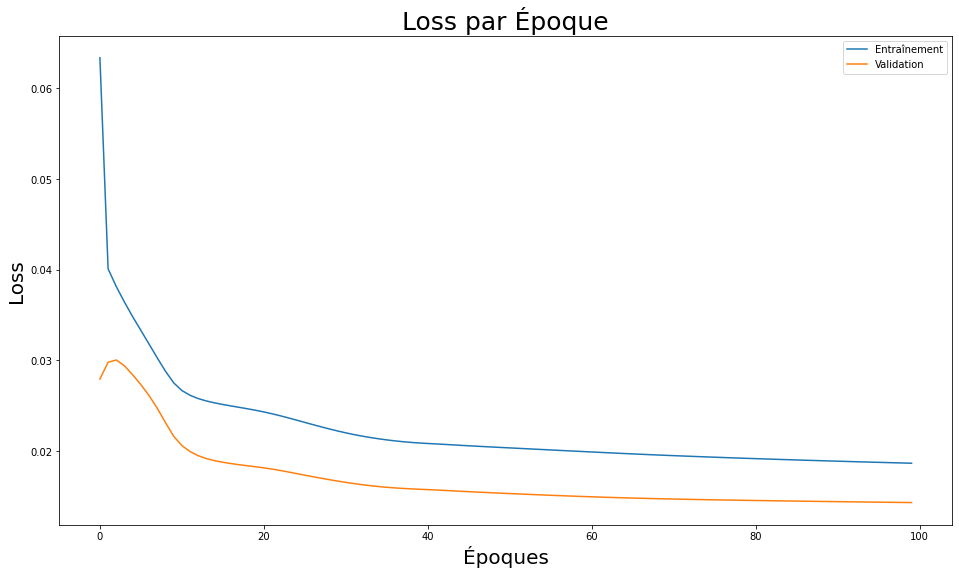

In [ ]:
plt.figure(figsize = (16, 9))
plt.plot(historique.history['loss'])
plt.plot(historique.history['val_loss'])
plt.title('Loss par Époque', size = 25)
plt.xlabel('Époques', size = 20)
plt.ylabel('Loss', size = 20)
plt.legend(['Entraînement', 'Validation'])

# Étape 6 : Réglage des paramètres (Parameter tuning)

Définition des callbacks pour régler les hyperparamètres :

In [ ]:
callbacks = [
    ReduceLROnPlateau(patience = 20, factor = 0.5, verbose = True),
    ModelCheckpoint('meilleur_regressor', save_best_only = True),
    EarlyStopping(monitor = 'val_loss', patience = 25, verbose = True)
]

Définition d'une fonction pour ajuster les hyperparamètres :

In [ ]:
def creer_reseau(neurone, optimizer):
  regressor = Sequential()
  regressor.add(LSTM(units = neurone, input_shape = (train_X.shape[1], 1)))
  regressor.add(Dense(1, activation = 'linear'))
  regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')
  return regressor

Définition des hyperparamètres :

In [ ]:
hyperparameters = {'neurone' : [ 100, 150],
              'optimizer' : ['adam', 'rmsprop']}

In [ ]:
regressor = KerasRegressor(build_fn = creer_reseau)
grid = GridSearchCV(estimator = regressor, param_grid = hyperparameters, scoring = 'neg_root_mean_squared_error', cv = 3)

In [ ]:
grid_result = grid.fit(train_X, train_Y, batch_size = batch_size , shuffle = False, validation_split = 0.2)

In [ ]:
meilleurs_résultats = grid_result.best_params_
meilleurs_résultats

{'neurone': 100, 'optimizer': 'adam'}

In [ ]:
meilleure_précision = grid_result.best_score_
meilleure_précision = round((np.sqrt(meilleure_précision * -1) * 100),2)
print('Performance du modèle de réseau neural : {} %'.format(meilleure_précision))

Performance du modèle de réseau neural : 43.53 %


### Ajustement du réseau neuronal LSTM avec les hyperparamètres améliorés :

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 100, input_shape = (train_X.shape[1], 1)))
regressor.add(Dense(1, activation = 'linear'))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

Entraînement du réseau de neurones ajusté :

In [ ]:
historique = regressor.fit(train_X, train_Y, epochs = 100 , batch_size = batch_size, verbose = 1, shuffle = False, validation_split = 0.2, callbacks = callbacks)

# Étape 7 : Prédiction (Prediction)

### À la fin des prévisions, nous avons replanifié les données à l'échelle d'origine et calculé les métriques RMSE :

In [ ]:
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((330, 3, 1), (161, 3, 1), (330,), (161,))

In [ ]:
# Exécuter des prédictions :
train_Predict = regressor.predict(train_X, batch_size = batch_size)
regressor.reset_states()
test_Predict = regressor.predict(test_X, batch_size = batch_size)

# Inverser les prédictions :
train_Predict = scaler.inverse_transform(train_Predict)
train_Y = scaler.inverse_transform([train_Y])
test_Predict = scaler.inverse_transform(test_Predict)
test_Y = scaler.inverse_transform([test_Y])

# Calculer la métrique RMSE (Root Mean Squared Error) :
train_Score = math.sqrt(mean_squared_error(train_Y[0], train_Predict[:,0]))
print('RMSE - score du train: %.4f' % (train_Score))
test_Score = math.sqrt(mean_squared_error(test_Y[0], test_Predict[:,0]))
print('RMSE - score du test: %.4f' % (test_Score))

train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

RMSE - score du train: 0.0139
RMSE - score du test: 0.0140


((330, 3, 1), (161, 3, 1), (1, 330), (1, 161))

Remplacement des prédictions d'entraînement pour le traçage :

In [ ]:
# Prédictions de train de décalage pour le plot :
train_PredictPlot = np.empty_like(df)
train_PredictPlot[:, :] = np.nan
train_PredictPlot[look_back : len(train_Predict) + look_back, :] = train_Predict

# Prédictions de test de décalage pour le plot :
test_PredictPlot = np.empty_like(df)
test_PredictPlot[:, :] = np.nan
test_PredictPlot[len(train_Predict) + (look_back*2) + 1 : len(df) - 1, :] = test_Predict

train_PredictPlot.shape, train_Predict.shape, test_PredictPlot.shape, test_Predict.shape

((499, 1), (330, 1), (499, 1), (161, 1))

Prédictions de base et de tracé :

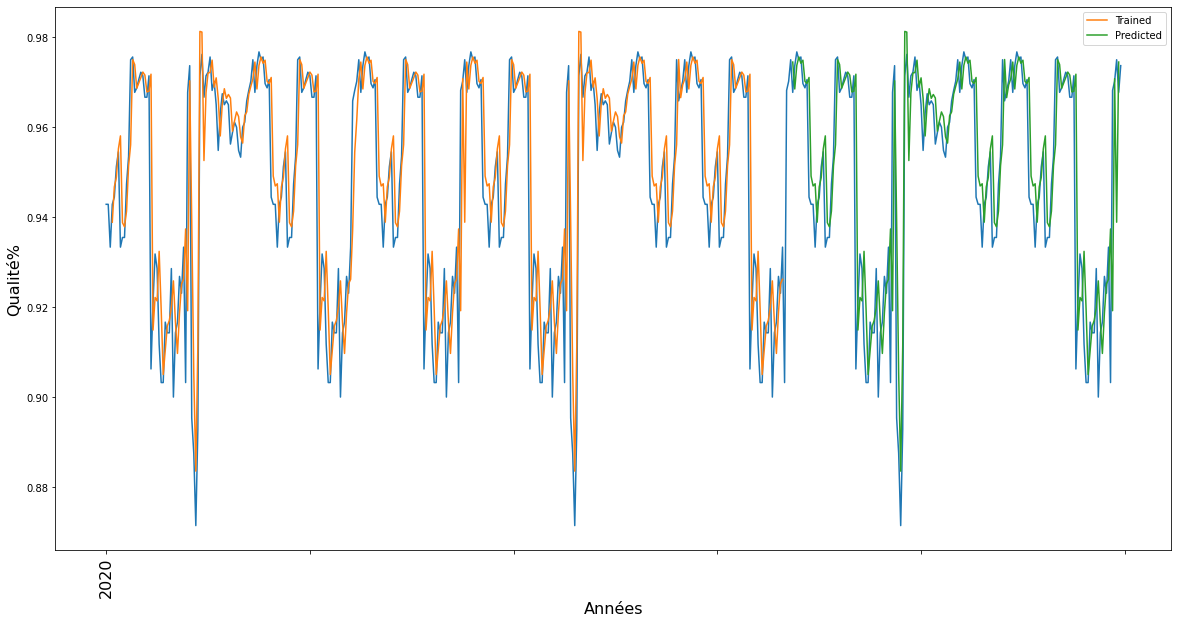

In [ ]:
# Tracer la ligne de base et les prévisions pour le plot :
fig, ax = plt.subplots(figsize = (20,10))
plt.plot(scaler.inverse_transform(df))
plt.plot(train_PredictPlot, label = 'Trained')
plt.plot(test_PredictPlot, label = 'Predicted')
ax.set_xlabel('Années', fontsize = 16)
ax.set_ylabel('Qualité%', fontsize = 16)
plt.legend(loc = 'best')
xticks = pd.date_range(datetime.datetime(2018,11,12), datetime.datetime(2020,3,24), freq = 'YS')
ax.set_xticklabels([x.strftime('%Y') for x in xticks], fontsize=16) 
plt.xticks(rotation=90)
plt.show()

# Enregistrement du réseau neuronal

In [ ]:
regressor_json = regressor.to_json()

Enregistrer la structure du réseau de neurones LSTM :

In [ ]:
with open('Regressor_OEE_ULaval.json', 'w') as json_file:
  json_file.write(regressor_json)

Enregistrer les poids du réseau de neurones LSTM :

In [ ]:
regressor.save_weights('Regressor_OEE_ULaval.h5')

### Chargement du réseau neuronal enregistré :

In [ ]:
fichier = open('/content/Regressor_OEE_ULaval.json', 'r')

In [ ]:
structure_reseau = fichier.read()

In [ ]:
fichier.close()

### Essayer le régresseur et évaluer sa performance :

In [ ]:
regressor = model_from_json(structure_reseau)

In [ ]:
regressor.load_weights('/content/Regressor_OEE_ULaval.h5')

In [ ]:
prevoir = regressor.predict(test_X)
prevoir.shape

(161, 1)

In [ ]:
test_Y = test_Y.T
test_Y.shape

(161, 1)

In [ ]:
test_Y = test_Y.reshape(len(test_Y), 1)
print('Performance du régresseur : {} %'.format(r2_score(test_Y, test_Predict).round(2)*100))

Performance du régresseur : 68.0 %


In [ ]:
! pip install nbconvert

In [ ]:
! pip install -e


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument


In [ ]:
! apt-get install pandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
! apt-get update
! apt-get install inkscape
! add-apt-repository universe
! add-apt-repository ppa: inkscape.dev/stable
! apt-get update
! apt install inkscape

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:12 http://ppa.launchpad.net/graphics-drive

In [ ]:
! apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-lato fonts-lmodern fonts-texgyre javascript-common libjs-jquery
  libkpathsea6 libptexenc1 libruby2.5 libsynctex1 libtexlua52 libtexluajit2
  libzzip-0-13 lmodern preview-latex-style rake ruby ruby-did-you-mean
  ruby-minitest ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  apache2 | lighttpd | httpd ri ruby-dev bundler debhelper perl-tk xpdf-reader
  | pdf-viewer texlive-fonts-recommended-doc texlive-latex-base-doc
  python-pygments icc-profiles libfile-which-perl
  libspreadsheet-parseexcel-perl texlive-latex-extra-doc
  texlive-latex-recommended-doc texlive-pstricks dot2tex prerex ruby-tcltk
  | libtcltk-rub

In [ ]:
jupyter nbconvert OEE_Prototype_V020.ipynb --to pdf 

SyntaxError: ignored